# SysArmy Surveys: Análisis por género de los resultados de todas las encuestas

Datos actualizados al 2do período de 2017

NOTA: Los primeros dos datasets no contienen información sobre género.

NOTA2: Los sueldos indicados son llevados a bruto, es decir, algunos encuestados optaron por informar sueldos netos,  estos valores netos fueron llevados a bruto mediante un cálculo simple pero a la vez impreciso.  Es importante aclarar que la imprecisión de la conversión tiende a la baja del salario, ya que no se tuvieron en cuenta descuentos por ganancias u otros beneficios.

### Datasets de sueldos

| Period  | Path             | URL                                                                                                         |
|---------|------------------|-------------------------------------------------------------------------------------------------------------|
| ~~2014.02~~ | data/2014.02.csv | https://drive.google.com/open?id=0B7UapTwn9AahWkdEWnltRjUwVjQ                                               |
| ~~2015.01~~ | data/2015.01.csv | https://drive.google.com/open?id=0B7UapTwn9AahSHl1aGNfTlNrYWc                                               |
| 2016.01 | data/2016.01.csv | https://drive.google.com/open?id=0B7UapTwn9AahLTJmSE5zOUQ0aGc                                               |
| 2016.02 | data/2016.02/    | https://drive.google.com/open?id=0B7UapTwn9AahUGtySFBjdHBCcWs                                               |
| 2017.01 | data/2017.01/    | https://docs.google.com/spreadsheets/d/1diZG7ruHJ4OgO2-tbnO-ZnhjxjOnYjMVSxl7I-4LT54/edit#gid=1424918437     |
| 2017.02 | data/2017.02/    | https://docs.google.com/spreadsheets/d/1f1CAmzbVtoL66IwXJWEf0Mn-QbMNGZIoCQ_b1HB-91E                         |


In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import cm
from functools import reduce
from IPython.display import display, Markdown as md

def getPeriodDF(period, publish_date, csv_path, columns_src, columns_dst, transforms = []):
    # given a csv_path, extract src columns into dst columns by applying a transform function for a certain period name
    df_src = pd.read_csv(csv_path)
    df_dst = pd.DataFrame(columns=['period', 'publish_date']+columns_dst)
    df_dst[columns_dst] = df_src[columns_src]
    df_dst['period'] = period
    df_dst['publish_date'] = pd.to_datetime(publish_date)
    # apply custom transformations
    for transform in transforms:
        df_src, df_dst = transform(df_src, df_dst)
    return df_dst

def transformNormalize(df_src, df_dst):
    # cast to float the salary column, some datasets gets wrongly parsed due to crappy user input
    df_dst['salary'] = df_dst['salary'].astype(float)
    df_dst['age'] = df_dst['age'].astype(str)
    # normalize stack column
    re_separator = ' *, *| *; *| *\. *| *\| *| *\/ *| *- *'
    re_garbage = '"""|\*|nan|='
    df_dst['stack'] = df_dst['stack'].apply(lambda s: re.split(re_separator, re.sub(re_garbage, '', str(s)).strip().lower()))
    # munge the dataset, removing entries that we consider not realistic for our analysis
    munging_mask = (df_dst.salary > 5000) & (df_dst.salary < 300000)
    df_src = df_src.loc[munging_mask]
    df_dst = df_dst.loc[munging_mask]
    return df_src, df_dst

def transformNet2Brute(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['Bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_dst));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1/0.83
    df_dst['salary'] = net_factor * df_dst['salary']
    return df_src, df_dst

def transformNet2Brute201702(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['¿Porcentaje, bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_dst));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1/0.83
    df_dst['salary'] = net_factor * df_dst['salary']
    return df_src, df_dst

src_common_cols = [
    'Tengo',
    'Años de experiencia',
    'Años en el puesto actual',
    'Trabajo de',
    'Tecnologías que utilizás']

dst_cols = [
    'salary',
    'location',
    'gender',
    'age',
    'yoe',
    'yip',
    'role',
    'stack']

df3 = getPeriodDF('2016.01', '2016-02-01', '../data/2016.01.csv', 
                  ['Salario mensual (AR$)', 'Trabajo en', 'Soy'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df4 = getPeriodDF('2016.02', '2016-08-01', '../data/2016.02/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina', 'Soy'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df5 = getPeriodDF('2017.01', '2017-02-01', '../data/2017.01/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina', 'Soy'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df6 = getPeriodDF('2017.02', '2017-09-01', '../data/2017.02/argentina.csv', 
                  ['Salario mensual (en tu moneda local)', 'Argentina', 'Me identifico'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute201702])

# compute the union of all the datasets as a signe pandas dataframe
df = pd.concat([df3, df4, df5, df6])

# extract the list of periods
periods = df.period.unique()

# extract the list of genders
genders = df.gender.unique()

# extract the list of yoes
yoes = df.yoe.unique()

display(md('## Géneros censandos en los datasets'))
[display(md('- %s (%d total)' % (g, len(df.query('gender == "%s"' % g))))) for g in genders]

## Géneros censandos en los datasets

- Hombre (16899 total)

- Mujer (1420 total)

- Otros (19 total)

[None, None, None]

In [2]:
# define arbitrary ranges for seniority
yoes_jr = ['1 - 2', 'Menos de un año', '1', '2', '3']
yoes_ssr = ['3 - 5', '3', '4', '5', '6']
yoes_sr = ['5 - 7', '8 - 10', '5', '6', '7', '8', '9', '10', '10+']

yoes_ranges = [yoes_jr, yoes_ssr, yoes_sr]
yoes_ranges_names = ['Juniors', 'Semi-Seniors', 'Seniors']

display(md("""
## Años de experiencia

El seniority fue simplificado en tres niveles, de los cuales se seleccionaron arbitrariamente los rangos
que conforman estos niveles.  Para evitar discrepancias, se sobrelaparon rangos en los diferentes niveles.
Por ejemplo, un desarrollador con 3 años de experiencia puede considerarse Junior ó Semi-Senior a la vez, eso
dependerá de cada caso.

### Sobre la categoría "Otros"

Al parecer, solo se registra el grupo "Otros" en el último dataset, donde se lo habría incluído.  Por la 
cantidad baja de resultados, y la ausencia de dimensión tiempo en los datasets, resulta imposible visualilzar dichos
resultados.

A continuación se detalla las cantidades por segmento y período de la muestra.
"""))

for i, gender in enumerate(genders):
    display(md('### %s' % gender))
    for j, yoes_range in enumerate(yoes_ranges):
        display(md('#### %s' % yoes_ranges_names[j]))
        [display(md('- %s año(s) (%d total)' % (y, len(df.query('gender == @gender & yoe in @y'))))) for y in yoes_range]


## Años de experiencia

El seniority fue simplificado en tres niveles, de los cuales se seleccionaron arbitrariamente los rangos
que conforman estos niveles.  Para evitar discrepancias, se sobrelaparon rangos en los diferentes niveles.
Por ejemplo, un desarrollador con 3 años de experiencia puede considerarse Junior ó Semi-Senior a la vez, eso
dependerá de cada caso.

### Sobre la categoría "Otros"

Al parecer, solo se registra el grupo "Otros" en el último dataset, donde se lo habría incluído.  Por la 
cantidad baja de resultados, y la ausencia de dimensión tiempo en los datasets, resulta imposible visualilzar dichos
resultados.

A continuación se detalla las cantidades por segmento y período de la muestra.


### Hombre

#### Juniors

- 1 - 2 año(s) (1288 total)

- Menos de un año año(s) (831 total)

- 1 año(s) (332 total)

- 2 año(s) (527 total)

- 3 año(s) (562 total)

#### Semi-Seniors

- 3 - 5 año(s) (2203 total)

- 3 año(s) (562 total)

- 4 año(s) (451 total)

- 5 año(s) (680 total)

- 6 año(s) (520 total)

#### Seniors

- 5 - 7 año(s) (1718 total)

- 8 - 10 año(s) (1602 total)

- 5 año(s) (680 total)

- 6 año(s) (520 total)

- 7 año(s) (460 total)

- 8 año(s) (461 total)

- 9 año(s) (431 total)

- 10 año(s) (0 total)

- 10+ año(s) (4833 total)

### Mujer

#### Juniors

- 1 - 2 año(s) (115 total)

- Menos de un año año(s) (98 total)

- 1 año(s) (40 total)

- 2 año(s) (61 total)

- 3 año(s) (62 total)

#### Semi-Seniors

- 3 - 5 año(s) (171 total)

- 3 año(s) (62 total)

- 4 año(s) (64 total)

- 5 año(s) (79 total)

- 6 año(s) (51 total)

#### Seniors

- 5 - 7 año(s) (94 total)

- 8 - 10 año(s) (101 total)

- 5 año(s) (79 total)

- 6 año(s) (51 total)

- 7 año(s) (51 total)

- 8 año(s) (47 total)

- 9 año(s) (52 total)

- 10 año(s) (0 total)

- 10+ año(s) (334 total)

### Otros

#### Juniors

- 1 - 2 año(s) (0 total)

- Menos de un año año(s) (0 total)

- 1 año(s) (2 total)

- 2 año(s) (0 total)

- 3 año(s) (3 total)

#### Semi-Seniors

- 3 - 5 año(s) (0 total)

- 3 año(s) (3 total)

- 4 año(s) (1 total)

- 5 año(s) (0 total)

- 6 año(s) (3 total)

#### Seniors

- 5 - 7 año(s) (0 total)

- 8 - 10 año(s) (0 total)

- 5 año(s) (0 total)

- 6 año(s) (3 total)

- 7 año(s) (1 total)

- 8 año(s) (1 total)

- 9 año(s) (0 total)

- 10 año(s) (0 total)

- 10+ año(s) (8 total)

## Participación en las encuestas por género

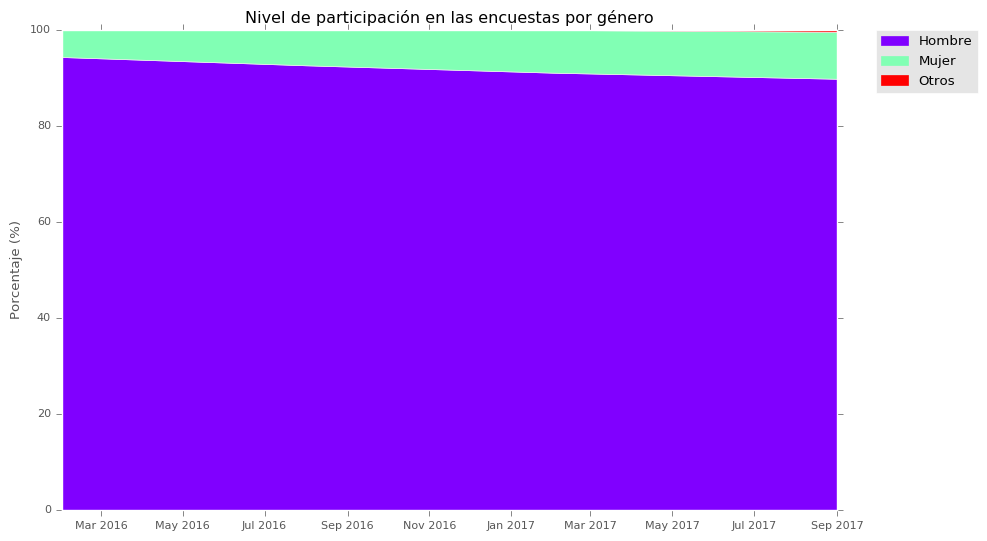

In [3]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use(['classic', 'ggplot'])
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})

genders_colors = cm.rainbow(np.linspace(0, 1, len(genders)))
publish_dates = np.unique(df['publish_date'])

y = []
for i, gender in enumerate(genders):
    gender_y = []
    for j, date in enumerate(publish_dates):
        count = df.query('gender == @gender & publish_date == @date').count()[0]
        gender_y.append(count)
    y.append(gender_y)

# define data points for stackplot
x = publish_dates
y = np.row_stack(y)
percent = np.divide(y, y.sum(axis=0).astype(float)*0.01)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.stackplot(x, percent, colors=genders_colors)
ax.set_title('Nivel de participación en las encuestas por género')
ax.set_ylabel('Porcentaje (%)')

display(md('## Participación en las encuestas por género'))

# creating the legend manually
plt.legend([mpatches.Patch(color=genders_colors[i]) for i, gender in enumerate(genders)],
           genders, 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

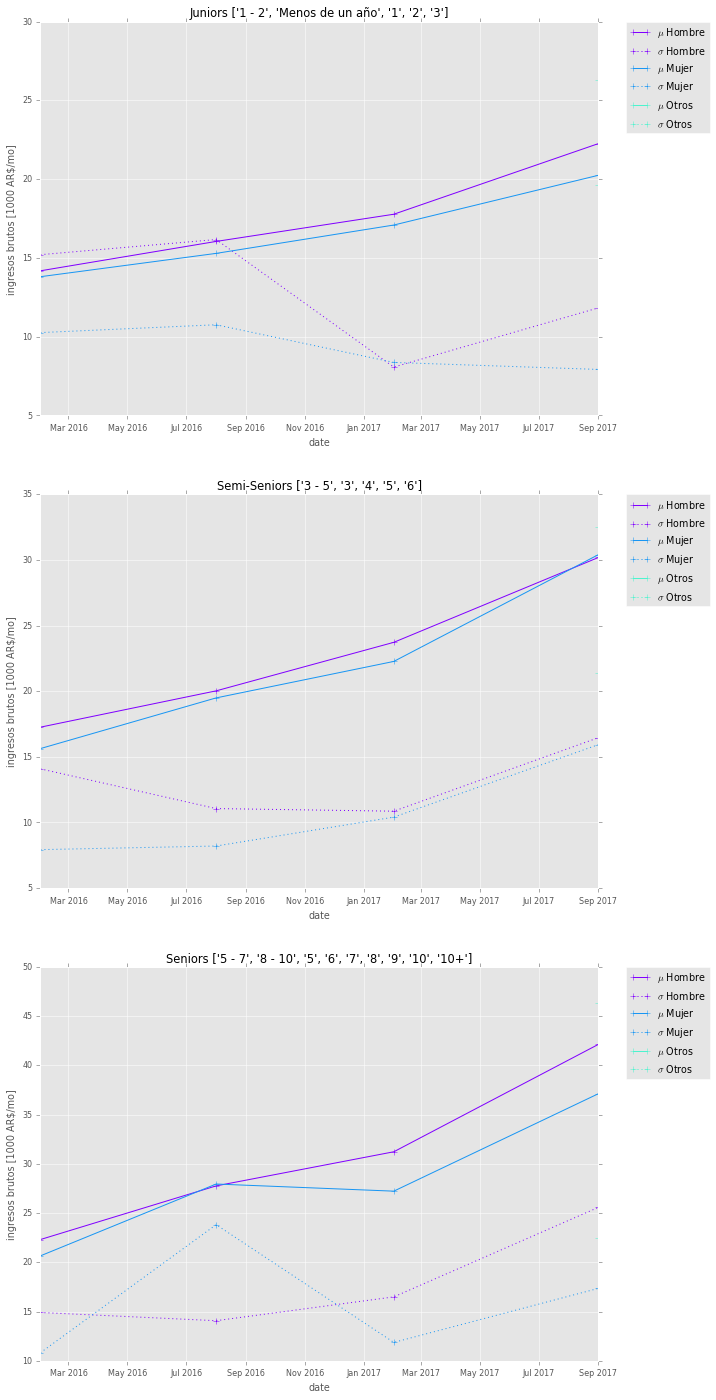

In [4]:
%matplotlib inline

def getPlotSalarySeries(currencySeries):
    s = currencySeries.apply(lambda x: float('{0:.2f}'.format(round(x/1000, 1))))
    mu, sigma = np.mean(s), np.std(s)
    median = np.median(s)
    t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    d = sigma**2/mu
    return mu, sigma, t, d, median, s

plt.rcParams.update({'figure.figsize': (10.0, 24.0), 'font.size': 8})
yoes_colors = cm.rainbow(np.linspace(0, 1, 2*len(yoes_ranges)))

dfnd = []

fig, ax = plt.subplots(len(yoes_ranges), 1)
for i, yoe_range in enumerate(yoes_ranges):
    for j, gender in enumerate(genders):
        mus, sigmas, dates = [], [], []
        for period in periods:
            dft = df.query('gender == @gender & period == @period & yoe in @yoe_range')
            if len(dft) == 0: continue
            mu, sigma, t, d, m, s = getPlotSalarySeries(dft.salary)
            mus.append(mu)
            sigmas.append(sigma)
            dates.append(np.max(dft['publish_date']))
            dfnd += [[gender, yoes_ranges_names[i], period, mu, sigma]]

        ax[i].plot(dates, mus, '+', label='$\mu$ %s' % gender, ls='-', c=yoes_colors[j])
        ax[i].plot(dates, sigmas, '+', label='$\sigma$ %s' % gender, ls=':', c=yoes_colors[j])
        ax[i].set_title('%s %s' % (yoes_ranges_names[i], yoe_range))

    ax[i].set_xlabel('date'); ax[i].set_ylabel('ingresos brutos [1000 AR$/mo]')
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.canvas.draw()

## Conclusión

Como es de público conocimiento, en la Industria del Software la desigualdad de género es muy remarcada.  Se puede observar sin embargo, una leve tendencia a revertir esta situación (ver primer gráfico).  Aunque cabe aclarar, como ya se presentó en el [análisis previo](https://github.com/gerardobort/sysarmy-data/blob/master/notebooks/intra_period_argentina.ipynb), existe una variación del espacio muestral en las encuestas de `SysArmy` a través del tiempo, lo cual puede interferir en los resultados.

Por otra parte, los niveles de ingresos censados presentan marcadas diferencias, sobre todo para puestos Seniors.  Este dato es también conocido en Argentina y el resto del mundo, y pudo corroborarse.  Se puede observar también, que la brecha salarial entre distíntos géneros no tiende a cerrarse en el caso de Seniors, sino por el contrario se ensancha.  Finalmente, para puestos de nivel medio, sí se observa una mejora en la reducción de la brecha salarial.

In [5]:
display(md("""
## Bonus track

Detalle de sueldos por período, seniority, y género.
Véase también [CESSI dio a conocer el salario de los Programadores en Argentina](http://www.cessi.org.ar/ver-noticias-cessi-dio-a-conocer-el-salario-de-los-programadores-en-argentina-2129)
"""))


dfn = pd.DataFrame(dfnd, columns=['Género', 'Seniority', 'period', 'Salario Bruto mensual', 'Desviación estándar'])
dfn

for i, period in enumerate(reversed(periods)):
    display(md('### %s' % period))
    display(dfn.query('period == @period'))


## Bonus track

Detalle de sueldos por período, seniority, y género.
Véase también [CESSI dio a conocer el salario de los Programadores en Argentina](http://www.cessi.org.ar/ver-noticias-cessi-dio-a-conocer-el-salario-de-los-programadores-en-argentina-2129)


### 2017.02

,Género,Seniority,period,Salario Bruto mensual,Desviación estándar
3,Hombre,Juniors,2017.02,22.257480,11.832849
7,Mujer,Juniors,2017.02,20.246903,7.922758
8,Otros,Juniors,2017.02,26.320000,19.660051
12,Hombre,Semi-Seniors,2017.02,30.186012,16.461985
16,Mujer,Semi-Seniors,2017.02,30.402632,15.933381
17,Otros,Semi-Seniors,2017.02,32.485714,21.407571
21,Hombre,Seniors,2017.02,42.138753,25.585862
25,Mujer,Seniors,2017.02,37.127532,17.357438
26,Otros,Seniors,2017.02,46.300000,22.502581


### 2017.01

,Género,Seniority,period,Salario Bruto mensual,Desviación estándar
2,Hombre,Juniors,2017.01,17.773200,8.071967
6,Mujer,Juniors,2017.01,17.087379,8.367328
11,Hombre,Semi-Seniors,2017.01,23.722034,10.861093
15,Mujer,Semi-Seniors,2017.01,22.267308,10.409393
20,Hombre,Seniors,2017.01,31.226782,16.490655
24,Mujer,Seniors,2017.01,27.227861,11.869105


### 2016.02

,Género,Seniority,period,Salario Bruto mensual,Desviación estándar
1,Hombre,Juniors,2016.02,16.047674,16.167943
5,Mujer,Juniors,2016.02,15.288732,10.758312
10,Hombre,Semi-Seniors,2016.02,20.026973,11.060387
14,Mujer,Semi-Seniors,2016.02,19.489873,8.208017
19,Hombre,Seniors,2016.02,27.762592,14.072298
23,Mujer,Seniors,2016.02,27.952239,23.824735


### 2016.01

,Género,Seniority,period,Salario Bruto mensual,Desviación estándar
0,Hombre,Juniors,2016.01,14.183154,15.205461
4,Mujer,Juniors,2016.01,13.808989,10.260655
9,Hombre,Semi-Seniors,2016.01,17.260857,14.086386
13,Mujer,Semi-Seniors,2016.01,15.630435,7.932456
18,Hombre,Seniors,2016.01,22.315252,14.905378
22,Mujer,Seniors,2016.01,20.658861,10.821493
